# Keras binary classifier tutorial

Part 1-5 of the instructions are based on https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Also, most of the textual description are taken or adaped from the same link.

## 1. Load Data



### Import packages
We import keras, for the neural network part, and numpy for dealing with the files and for transforming the data into the right matricial format.

Also, we set a specified random seed for reproducibility

In [1]:
import keras

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
sns.mpl.rc("figure", figsize=(8,8))
sns.set_context(context = 'poster')



print('Imported keras version', keras.__version__)

Using TensorFlow backend.


Imported keras version 2.0.8


### Import data
We use the  *Pima Indians onset of diabetes* dataset, available from http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data.

N.B. download the dataset and save it as a csv file in the same folder as this notebook.

In [2]:
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

In [3]:
print(X.shape)
input_dim = X.shape[1]

(768, 8)


In [11]:
print(Y[0:10])

[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  1.]


We have 768 observations of 8 variables (X) plus 1 target variable (Y). The target variable is binary.

## 2. Define Model

We create a Sequential model and add layers one at a time until we are happy with our network topology.

- The first thing to get right is to ensure the input layer has the right number of inputs. This can be specified when creating the first layer with the **input_dim** argument and setting it to 8 for the 8 input variables.

- In this example, we will use a **fully-connected network** structure with three layers. Fully connected layers are defined using the **Dense** class. We can specify the number of neurons in the layer as the first argument, the initialization method as the second argument as init and specify the activation function using the activation argument.

- In this case, we initialize the network weights to a small random number generated from a **uniform distribution** (‘uniform‘), in this case between 0 and 0.05 because that is the default uniform weight initialization in Keras. Another traditional alternative would be *normal* for small random numbers generated from a Gaussian distribution. 

- We will use the rectifier (**‘relu‘**) activation function on the first two layers and the **sigmoid** function in the output layer. The reason is that using relu the training is generally faster without deteriorating the performance. On the other hand, the sigmoid is used because it allows the output to be in the 0-1 range, which is easily interpretable as a probability.







In [4]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## 3. Compile Model
Compiling the model uses the efficient numerical libraries under the covers (the so-called backend), in this case TensorFlow. 

Here, we specify:

1) the **loss function** to evaluate the weights, in this example a *logloss*, which for a binary classification problem is defined in Keras as **“binary_crossentropy“**.

2) the **optimizer** to search the space of the possible weights, here we use **adam** (Adaptive Moment Estimation) which is an efficient version of gradient descent (see http://ruder.io/optimizing-gradient-descent/ or in the original paper https://arxiv.org/pdf/1412.6980.pdf)

3) the (optional) **metrics** to be collected and reported during the training phase, in this case the **accuracy**


In [5]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 4. Fit Model

The training function, called **fit** requires two arguments:

1) the number of **epochs**, or iterations through the dataset;

2) the number of instances that are evaluated before a weight update in the network is performed, called **batch size**

For this problem, we will run for a small number of iterations (150) and use a relatively small batch size of 10. Again, these can be chosen experimentally by trial and error.

N.B. here, given the small nature of our dataset, we do not perform a **train-test split**, which is generally required to properly evaluate the performance of a model.

In [6]:
# Fit the model
model.fit(X, Y, epochs=150, batch_size=10)

Epoch 1/150
768/768 [==============================] - 0s - loss: 3.7513 - acc: 0.6003     
Epoch 2/150
768/768 [==============================] - 0s - loss: 0.9439 - acc: 0.5951     
Epoch 3/150
768/768 [==============================] - 0s - loss: 0.7515 - acc: 0.6380     
Epoch 4/150
768/768 [==============================] - 0s - loss: 0.7133 - acc: 0.6549     
Epoch 5/150
768/768 [==============================] - 0s - loss: 0.6830 - acc: 0.6719     
Epoch 6/150
768/768 [==============================] - 0s - loss: 0.6518 - acc: 0.6810     
Epoch 7/150
768/768 [==============================] - 0s - loss: 0.6503 - acc: 0.6771     
Epoch 8/150
768/768 [==============================] - 0s - loss: 0.6384 - acc: 0.6836     
Epoch 9/150
768/768 [==============================] - 0s - loss: 0.6253 - acc: 0.6940     
Epoch 10/150
768/768 [==============================] - 0s - loss: 0.6318 - acc: 0.6758     
Epoch 11/150
768/768 [==============================] - 0s - loss: 0.6501 - acc

## 5. Evaluate Model

We have trained our neural network on the entire dataset and we can evaluate the performance of the network on the same dataset (see comment above on train-test split). 

You can evaluate your model on your training dataset using the evaluate() function on your model and pass it the same input and output used to train the model.

This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.



In [7]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

 32/768 [>.............................] - ETA: 0s
acc: 78.26%


## 6. Making predictions and ROC curve

To go one step further, we retrain the model on different train-test splits and try to measure the performance.
We start by importing the packages for performing a **stratified K fold**, and to compute and plot a **ROC** curve, as well as the **AUC** (Area under the curve) metrics.

The ROC tries to capture how a classifier performs with different thresholds. It consists of the performance of the classifier in terms of **true positive rate** (tpr) against **false positive rate** (fpr) while varying the threshold. Starting from an extremely high threshold, the model will classify everything as negative. Therefore, both the tpr and the fpr will be zero. On the other extreme, with a zero threshold, everything will be classified as positive, resulting in 100% recall and tpr, at the price of having a 100% false positives.
With thresholds in between the extreme values, a naive (random) classifier, will have the same tpr and fpr. The better the non-naive classifier is, the more it will outperform the naive classifier for evey value of the threshold. 

The AUC is a measure of the performance based on the area under the curve of a ROC curve. The ROC curve of a naive classifier is a diagonal with area under the curve of 0.5; a perfect classifier would have AUC of 1 (tpr = 100% and fpr = 0%).

### Importing the packages for stratified K fold, ROC curve, and AUC


In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

### Define the number of splits. 
We use a fix random state for reproducibility. Also, we initialize the listes where to save true positive rates, AUCs and average fpr.


In [9]:
cv = StratifiedKFold(n_splits=10, random_state=7)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

### Train, predict, compute AUCs
For every train-test split computed by cv.split(X, Y), we train the model, predict and compute the ROC/AUC.

The ROC is plotted for each split. Eventually, the average is calculated and an *overall* ROC and AUC are presented in a plot form.


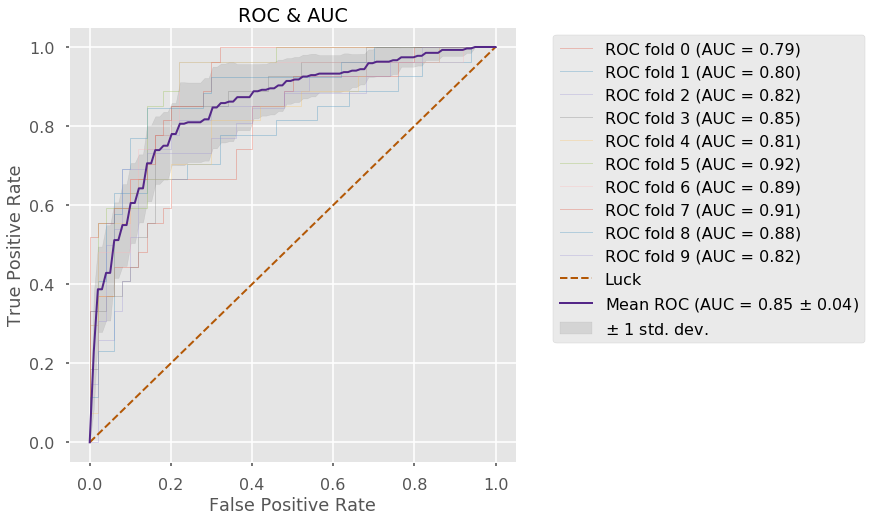

In [10]:
i = 0
for train, test in cv.split(X, Y):
    #train and predict
    model.fit(X[train], Y[train], verbose=0)
    predicted_on_test = model.predict((X[test]))
    # Compute false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(Y[test], predicted_on_test)
    #save in a list fpr and tpr for future use
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # Compute ROC and AUC
    roc_auc = auc(fpr, tpr)
    
    # Save the roc/auc in a list for later use
    aucs.append(roc_auc)
    
    #Plot the roc for each specific split
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    
    
    
## Plot the average and standard deviation of the ROCs, as well as a naive prediction curve (random prediction)
## Naive
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#b35806',
         label='Luck')

## Mean
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='#542788',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2)

# Standard deviation
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

##Plot labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', ncol=1)
